<center>
<img src="http://www.gonella.biz/assets/consel.jpg">
</center>

## Import libraries

In [1]:
%pylab inline
import pandas as pd
import numpy as np
from numpy import concatenate
from sklearn import metrics, preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import cross_validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import StratifiedKFold
from sklearn import grid_search

Populating the interactive namespace from numpy and matplotlib


## Import data

####Import loans

In [2]:
sella = pd.read_csv('../data/Sample_consel.csv', sep=';', quotechar="'")  
sella.shape

(24110, 60)

####Import geo IP

In [3]:
sella_ip = pd.read_csv('../data/geolocalized_loans.csv', sep=',')
sella_ip = sella_ip.ix[:,['LOAN_NUMBER','IP_COUNTRY','IP_EQ_RES','EMP_EQ_RES','IP_EQ_EMP']]

sella_ip.shape

(24110, 5)

####Merge dataframe

In [4]:
sella = pd.merge(sella, sella_ip, how ='left', on='LOAN_NUMBER')

## Clean data

####Remove duplicates

In [5]:
sella = sella.drop_duplicates("LOAN_NUMBER")  

####Set contract_number as index 

In [6]:
sella = sella.set_index('LOAN_NUMBER')

####Drop rejected & retried loans

In [7]:
sella = sella[sella.LOAN_STATE != 'REJECT_LOAN']
sella = sella[sella.LOAN_STATE != 'RETRAED_LOAN']

####Count missing values

In [8]:
sella.isnull().sum()

DEFAULT                       0
DEFAULT_AMOUNT                0
LOAN_AMOUNT                   0
LOAN_INSTALMENT_AMOUNT        0
LOAN_NUMBER_OF_INSTALMENTS    0
LOAN_RATING                   0
LOAN_STATE                    0
LOAN_IRREGULARITY             0
LOAN_SYSTEM_ACCEPT            0
LOAN_SYSTEM_REJECT            0
LOAN_DATE                     0
ALERT_14                      0
ALERT_15                      0
ALERT_46                      0
ALERT_55                      0
...
CUSTOMER_EMPLOYER_PHONE_NUMBER     2203
CUSTOMER_EMPLOYER_CAP_CODE            0
RULE_EMAIL_OTHER_CONTRACT             0
RULE_NOT_REGISTERED_FOREIGN           0
RULE_TELEF_DOC_ALTRA_PRT              0
T_CREDIT_CARD_GRANTED                 0
T_CREDIT_CARD_EXTINCT                 0
T_CREDIT_CARD_REJECTED               13
T_NR_RESIDENCE                        0
T_PERFORM                            97
T_NOTIFICATION                        0
IP_COUNTRY                         7077
IP_EQ_RES                         12

## Features Engineering

####Add transactions counter by Customer Code

In [9]:
sella['count'] = sella.groupby(['CUSTOMER_CODE'])['CUSTOMER_CODE'].transform('count').astype('int')

sella['CUSTOMER_STATUS'] = 0
sella['CUSTOMER_STATUS'][sella['count']>3] = 1

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


####Extract day of the week

In [10]:
import datetime

sella['LOAN_DATE'] = np.array([datetime.datetime.strptime(x, "%Y-%m-%d").date() for x in sella['LOAN_DATE']])
sella['WEEKDAY'] = sella.LOAN_DATE.apply(lambda x: x.isoweekday())

####Aggregate Mails Info

In [11]:
sella['CUSTOMER_EMAIL'] = sella['CUSTOMER_EMAIL'].apply(lambda x: str(x).split(" ")[0])

sella['EMAIL_TLD'] = sella['CUSTOMER_EMAIL'].apply(lambda x: str(x).split(".")[-1])
sella['EMAIL_SLD'] = sella['CUSTOMER_EMAIL'].apply(lambda x: str(x).rsplit(".",1)[0])

sella['EMAIL_TLD_STATUS'] = 'NaN'

# gruppo mail da dominio italiano
sella['EMAIL_TLD_STATUS'][sella.EMAIL_TLD=="it"] = 'ita'

# gruppo mail da dominio generico
sella['EMAIL_TLD_STATUS'][sella.EMAIL_TLD.isin(['com','org','net','biz','eu','info','tv'])]= 'gen'

# gruppo mail da dominio straniero
sella['EMAIL_TLD_STATUS'][sella.EMAIL_TLD.isin(['uk', 'pl', 'ro', 'es', 'fr', 'lv', 'br',  
                                                'ie', 'ru', 'hu', 'dk', 'de', 'ch', 'ca', 'co', 'bg', 'edu'])] ='str'

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [12]:
# raggruppo mail che non sono provider di posta
sella['EMAIL_SLD_STATUS'] = sella['EMAIL_SLD']

sella['EMAIL_SLD_STATUS'][~sella.EMAIL_SLD.isin(['gmail','libero','hotmail','alice','yahoo','tiscali','virgilio',
                                                'live','tin','fastwebnet','inwind', 'email', 'vodafone','me',
                                               'icloud','msn','teletu','outlook','katamail','ymail','poste', 
                                                'telecomitalia', 'iol','interfree','tiscalinet','infinito',
                                                'istruzione','excite','ngi','pec','fastwebmail','aruba',
                                               'aliceposta','rocketmail','googlemail','mail','yahoo.co','tim',
                                               'gmx'])]= 'pri'

sella['EMAIL_SLD_STATUS'][sella['EMAIL_SLD']=='nan'] = 'NaN'

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


###IP not in Italy

In [13]:
sella['COUNTRY_IP'] = 'NaN'
sella['COUNTRY_IP'][sella['IP_COUNTRY']=='Italy']= 'Italy'
sella['COUNTRY_IP'][sella.IP_COUNTRY.isin(['France','Brazil','Germany','Switzerland','Tunisia','United States',
                                       'Netherlands','China','Slovenia','United Kingdom','Republic of the Congo',
                                       'Morocco','Romania','Qatar'])]= 'Abroad'

sella['COUNTRY_IP'].unique()

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


array(['Italy', 'NaN', 'Abroad'], dtype=object)

#### Customer Phone Operator

In [14]:
tim = list(map(str, (330, 331, 333, 334, 335, 336, 337, 338, 339, 360, 361, 362, 363, 366, 368, 385)))
vodafone = list(map(str, (340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 383)))
wind = list(map(str, (320, 322, 323, 324, 327, 328, 329, 380, 383, 388, 389)))
tre = list(map(str, (390, 391, 392, 393, 397)))
big4 = tim+vodafone+wind+tre

In [15]:
def phone_operator(digits):
    digits = str(digits)
    if digits=='nan': return None
    if digits[0]=='3':
        if digits[:3] in big4:
            return "mobile_big"
        else:
            return "mobile_strange"
    else:
        return "fixed"
sella['CUSTOMER_PHONE_OPERATOR'] = sella.CUSTOMER_PHONE_NUMBER.apply(phone_operator)

### T_perform missing --> metto = 0 

In [16]:
sella['T_PERFORM'][sella['T_PERFORM'].isnull()] = 0

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


## Convert feature formatting

####Drop unmeaningful variables

In [17]:
sella.drop('DEFAULT_AMOUNT', axis=1, inplace=True)
sella.drop('LOAN_STATE', axis=1, inplace=True)
sella.drop('count', axis=1, inplace=True)
sella.drop('EMAIL_SLD', axis=1, inplace=True)
sella.drop('EMAIL_TLD', axis=1, inplace=True) 
sella.drop('LOAN_DATE', axis=1, inplace=True) 

####Formatting

In [18]:
# convert dtype for contract rating 

from sklearn.preprocessing import LabelEncoder  

booleans = ['ALERT_14','ALERT_15','ALERT_46','ALERT_55','ALERT_61','ALERT_62','ALERT_64',
           'ALERT_69','ALERT_72','ALERT_74','ALERT_77','ALERT_84','ALERT_87','ALERT_88','ALERT_90','ALERT_91',
           'ALERT_92','ALERT_93','ALERT_94','RULE_EMAIL_OTHER_CONTRACT','RULE_NOT_REGISTERED_FOREIGN',
           'RULE_TELEF_DOC_ALTRA_PRT','CUSTOMER_STATUS']

floatings = ['LOAN_AMOUNT'] # 'LOAN_INSTALMENT_AMOUNT','CUSTOMER_SENIORITY_ADDRESS','CUSTOMER_SENIORITY_EMPLOY'

integers = ['CUSTOMER_AGE','LOAN_NUMBER_OF_INSTALMENTS','T_PERFORM',
            'T_CREDIT_CARD_GRANTED ','T_CREDIT_CARD_EXTINCT','T_NR_RESIDENCE','T_NOTIFICATION']

category = ['LOAN_RATING']
            
string = ['CUSTOMER_HOUSING', 'CUSTOMER_NATIONALITY_AREA', 'CUSTOMER_EMPLOY', 'CUSTOMER_MARITAL_STATUS',
          'WEEKDAY','T_CREDIT_CARD_REJECTED','EMAIL_SLD_STATUS', 'EMAIL_TLD_STATUS', 'CUSTOMER_PHONE_OPERATOR',
          'COUNTRY_IP', 'IP_EQ_RES','EMP_EQ_RES','IP_EQ_EMP']


for b in booleans:
    sella[b] = sella[b].astype("bool")

for b in floatings:
    sella[b] = sella[b].astype("float_")

for b in category:
    sella[b] = sella[b].astype("category")   
    
for b in integers:
    sella[b] = sella[b].astype("int_")
    
for b in string:
    sella[b] = LabelEncoder().fit_transform(sella[b]).astype("int_")

## Get labels y and features X

In [36]:
y = sella["DEFAULT"] 
X = sella.ix[:, floatings+integers+category+booleans+string]

X.head()

LOAN_AMOUNT  CUSTOMER_AGE  LOAN_NUMBER_OF_INSTALMENTS  T_PERFORM  \
LOAN_NUMBER                                                                     
3051065              610            62                          12        565   
2900179             1001            42                           6        478   
2822295              212            56                           6        520   
2900451              385            44                           6        531   
2840121              739            74                           6        571   

             T_CREDIT_CARD_GRANTED   T_CREDIT_CARD_EXTINCT  T_NR_RESIDENCE  \
LOAN_NUMBER                                                                  
3051065                           1                      0               2   
2900179                           0                      0               0   
2822295                           1                      0               5   
2900451                           2                      0               1   
2840121                           0                      2              12   

             T_NOTIFICATION LOAN_RATING ALERT_14    ...     \
LOAN_NUMBER                                         ...      
3051065                   1           6    False    ...      
2900179                   0           9    False    ...      
2822295                   5           9    False    ...      
2900451                   3           9    False    ...      
2840121                   5           9    False    ...      

            CUSTOMER_MARITAL_STATUS WEEKDAY T_CREDIT_CARD_REJECTED  \
LOAN_NUMBER                                                          
3051065                           0       1                      0   
2900179                           1       4                      0   
2822295                           1       6                      0   
2900451                           1       4                      0   
2840121                           1       3                      0   

            EMAIL_SLD_STATUS EMAIL_TLD_STATUS CUSTOMER_PHONE_OPERATOR  \
LOAN_NUMBER                                                             
3051065                   19                2                       1   
2900179                    1                2                       1   
2822295                   28                2                       1   
2900451                    8                1                       1   
2840121                   34                2                       1   

            COUNTRY_IP IP_EQ_RES EMP_EQ_RES IP_EQ_EMP  
LOAN_NUMBER                                            
3051065              1         0          2         0  
2900179              2         0          2         0  
2822295              2         0          2         0  
2900451              2         0          2         0  
2840121              1         0          2         0  

[5 rows x 45 columns]

## Feature Selection

### Grid Search

The following algorithm looks for the parameters of the Random Forest Classification Model that maximize the Roc-auc metrics:

In [22]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0, class_weight = 'auto')

param_grid = {'n_estimators': np.arange(40,160, step = 10), 'max_depth': np.arange(3,9, step=1)}
gs = grid_search.GridSearchCV(model,  param_grid = param_grid, cv=StratifiedKFold(y, 10,shuffle=True), 
                              scoring='roc_auc')
gs.fit(X,y)

print gs.best_params_ , gs.best_score_

n_estimators_param = gs.best_params_["n_estimators"]  
max_depth_param = gs.best_params_["max_depth"]   

{'n_estimators': 150, 'max_depth': 8} 0.890871919398


{'n_estimators': 150, 'max_depth': 8} 0.890871919398

### Feature Selection

This algorithm automatically selects the features that enter the model in order to maximize the Roc-auc metrics.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

class RandomForestClassifierWithCoef(RandomForestClassifier):
    def fit(self, *args, **kwargs):
        super(RandomForestClassifierWithCoef, self).fit(*args, **kwargs)
        self.coef_ = self.feature_importances_
        
rf = RandomForestClassifierWithCoef(random_state=0, n_estimators=n_estimators_param, max_depth=max_depth_param, 
                                    class_weight = 'auto')  

# Create the RFE object and compute a cross-validated score.
rfecv = RFECV(estimator=rf, step=1, cv=StratifiedKFold(y, 10, shuffle=True), scoring='roc_auc' )
rfecv.fit(X, y)

RFECV(cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=10, shuffle=True, random_state=None),
   estimator=RandomForestClassifierWithCoef(bootstrap=True, class_weight='auto',
                criterion='gini', max_depth=8, max_features='auto',
                max_leaf_nodes=None, min_samples_leaf=1,
                min_samples_split=2, min_weight_fraction_leaf=0.0,
                n_estimators=150, n_jobs=1, oob_score=False,
                random_state=0, verbose=0, warm_start=False),
   estimator_params=None, scoring='roc_auc', step=1, verbose=0)

### Select the most important features

Optimal number of features : 28


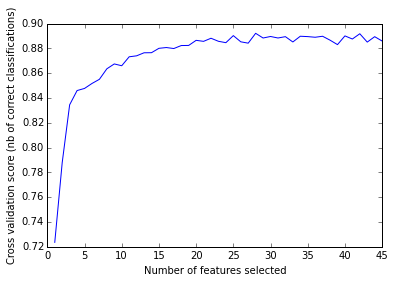

In [25]:
import matplotlib.pyplot as plt
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show() 

In [26]:
feature_names = np.array(X.columns.values) 

print "Features sorted by their score:"
print sorted(zip(map(lambda x: round(x, 4), rfecv.grid_scores_), feature_names), reverse=True)

Features sorted by their score:
[(0.8922, 'ALERT_94'), (0.8918, 'COUNTRY_IP'), (0.8903, 'ALERT_91'), (0.8901, 'EMAIL_TLD_STATUS'), (0.8898, 'WEEKDAY'), (0.8898, 'CUSTOMER_NATIONALITY_AREA'), (0.8896, 'RULE_NOT_REGISTERED_FOREIGN'), (0.8895, 'EMP_EQ_RES'), (0.8895, 'CUSTOMER_STATUS'), (0.8895, 'CUSTOMER_EMPLOY'), (0.889, 'CUSTOMER_MARITAL_STATUS'), (0.8884, 'RULE_TELEF_DOC_ALTRA_PRT'), (0.8884, 'RULE_EMAIL_OTHER_CONTRACT'), (0.8882, 'ALERT_87'), (0.8876, 'CUSTOMER_PHONE_OPERATOR'), (0.8866, 'T_CREDIT_CARD_REJECTED'), (0.8865, 'ALERT_77'), (0.8859, 'IP_EQ_EMP'), (0.8857, 'ALERT_88'), (0.8857, 'ALERT_84'), (0.8853, 'ALERT_92'), (0.8852, 'CUSTOMER_HOUSING'), (0.8851, 'IP_EQ_RES'), (0.8846, 'ALERT_90'), (0.8842, 'ALERT_93'), (0.883, 'EMAIL_SLD_STATUS'), (0.8824, 'ALERT_74'), (0.8823, 'ALERT_72'), (0.8807, 'ALERT_64'), (0.8801, 'ALERT_62'), (0.8799, 'ALERT_69'), (0.8765, 'ALERT_61'), (0.8765, 'ALERT_55'), (0.874, 'ALERT_46'), (0.8732, 'ALERT_15'), (0.8675, 'LOAN_RATING'), (0.866, 'ALERT_14')

Features sorted by their score:
[(0.8922, 'ALERT_94'), (0.8918, 'COUNTRY_IP'), (0.8903, 'ALERT_91'), (0.8901, 'EMAIL_TLD_STATUS'), (0.8898, 'WEEKDAY'), (0.8898, 'CUSTOMER_NATIONALITY_AREA'), (0.8896, 'RULE_NOT_REGISTERED_FOREIGN'), (0.8895, 'EMP_EQ_RES'), (0.8895, 'CUSTOMER_STATUS'), (0.8895, 'CUSTOMER_EMPLOY'), (0.889, 'CUSTOMER_MARITAL_STATUS'), (0.8884, 'RULE_TELEF_DOC_ALTRA_PRT'), (0.8884, 'RULE_EMAIL_OTHER_CONTRACT'), (0.8882, 'ALERT_87'), (0.8876, 'CUSTOMER_PHONE_OPERATOR'), (0.8866, 'T_CREDIT_CARD_REJECTED'), (0.8865, 'ALERT_77'), (0.8859, 'IP_EQ_EMP'), (0.8857, 'ALERT_88'), (0.8857, 'ALERT_84'), (0.8853, 'ALERT_92'), (0.8852, 'CUSTOMER_HOUSING'), (0.8851, 'IP_EQ_RES'), (0.8846, 'ALERT_90'), (0.8842, 'ALERT_93'), (0.883, 'EMAIL_SLD_STATUS'), (0.8824, 'ALERT_74'), (0.8823, 'ALERT_72'), (0.8807, 'ALERT_64'), (0.8801, 'ALERT_62'), (0.8799, 'ALERT_69'), (0.8765, 'ALERT_61'), (0.8765, 'ALERT_55'), (0.874, 'ALERT_46'), (0.8732, 'ALERT_15'), (0.8675, 'LOAN_RATING'), (0.866, 'ALERT_14'), (0.8635, 'T_NOTIFICATION'), (0.8551, 'T_NR_RESIDENCE'), (0.8517, 'T_CREDIT_CARD_EXTINCT'), (0.8477, 'T_CREDIT_CARD_GRANTED '), (0.846, 'T_PERFORM'), (0.8345, 'LOAN_NUMBER_OF_INSTALMENTS'), (0.7879, 'CUSTOMER_AGE'), (0.7236, 'LOAN_AMOUNT')]

### Print the variable that are automatically selected

In [28]:
subsample = rfecv.support_[rfecv.support_==True]

lista = zip(map(lambda x: round(x, 4), subsample), feature_names)

X_new = [x[1] for x in lista]

In [29]:
print X_new

['LOAN_AMOUNT', 'CUSTOMER_AGE', 'LOAN_NUMBER_OF_INSTALMENTS', 'T_PERFORM', 'T_CREDIT_CARD_GRANTED ', 'T_CREDIT_CARD_EXTINCT', 'T_NR_RESIDENCE', 'T_NOTIFICATION', 'LOAN_RATING', 'ALERT_14', 'ALERT_15', 'ALERT_46', 'ALERT_55', 'ALERT_61', 'ALERT_62', 'ALERT_64', 'ALERT_69', 'ALERT_72', 'ALERT_74', 'ALERT_77', 'ALERT_84', 'ALERT_87', 'ALERT_88', 'ALERT_90', 'ALERT_91', 'ALERT_92', 'ALERT_93', 'ALERT_94']


['LOAN_AMOUNT', 'CUSTOMER_AGE', 'LOAN_NUMBER_OF_INSTALMENTS', 'T_PERFORM', 'T_CREDIT_CARD_GRANTED ', 'T_CREDIT_CARD_EXTINCT', 'T_NR_RESIDENCE', 'T_NOTIFICATION', 'LOAN_RATING', 'ALERT_14', 'ALERT_15', 'ALERT_46', 'ALERT_55', 'ALERT_61', 'ALERT_62', 'ALERT_64', 'ALERT_69', 'ALERT_72', 'ALERT_74', 'ALERT_77', 'ALERT_84', 'ALERT_87', 'ALERT_88', 'ALERT_90', 'ALERT_91', 'ALERT_92', 'ALERT_93', 'ALERT_94']

These are the features that are automatically selected based on by their importance in maximizing the ROC metrics.

### Train the model with the selected features

In [40]:
X = X.ix[:,X_new]

#### Grid Search

In [41]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=0, class_weight = 'auto')

param_grid = {'n_estimators': np.arange(40,160, step = 10), 'max_depth': np.arange(3,9, step=1)}
gs = grid_search.GridSearchCV(model,  param_grid = param_grid, cv=StratifiedKFold(y, 10,shuffle=True), scoring='roc_auc')
gs.fit(X,y)

print gs.best_params_ , gs.best_score_

n_estimators_param = gs.best_params_["n_estimators"]  
max_depth_param = gs.best_params_["max_depth"]   

{'n_estimators': 140, 'max_depth': 6} 0.884206450657


{'n_estimators': 140, 'max_depth': 6} 0.884206450657

#### Cross validation

In [42]:
# Weighted Random Forest Classifier - Stratified samples
model_opt = RandomForestClassifier(random_state=0, n_estimators=n_estimators_param, max_depth=max_depth_param,
                                   class_weight = 'auto')
# Cross-validation and metrics
fraud_proba =[]
cv_T = np.zeros([2,2], dtype="int")
feature_importance = np.zeros([X.shape[1]])
recalls = []
roc = []

for train_index, test_index in cross_validation.StratifiedKFold(list(y.values), 221, shuffle=True):
    model_opt.fit(X.iloc[train_index], y.iloc[train_index])
    predictions = model_opt.predict(X.iloc[test_index])
    predict_prob = [i[1] for i in model_opt.predict_proba(X.iloc[test_index])]
    
    cv        = metrics.confusion_matrix(y.iloc[test_index],predictions)
    cv_T += cv
    
    recalls.append(metrics.recall_score(y.iloc[test_index],predictions))
    roc.append(metrics.roc_auc_score(y.iloc[test_index],predict_prob, average = None))

    feature_importance += model_opt.feature_importances_
    
recall_T = np.mean(recalls)
roc_T = np.mean(roc)

print "Confusion Matrix: "
print cv_T 
print "Recall Metrics: ",recall_T
print "Roc-Auc Curve: ", roc_T

Confusion Matrix: 
[[17437  1651]
 [   79   142]]
Recall Metrics:  0.642533936652
Roc-Auc Curve:  0.887283628521


Confusion Matrix: 
[[17437  1651]
 [   79   142]]
Recall Metrics:  0.642533936652
Roc-Auc Curve:  0.887283628521

#### Feature Importance

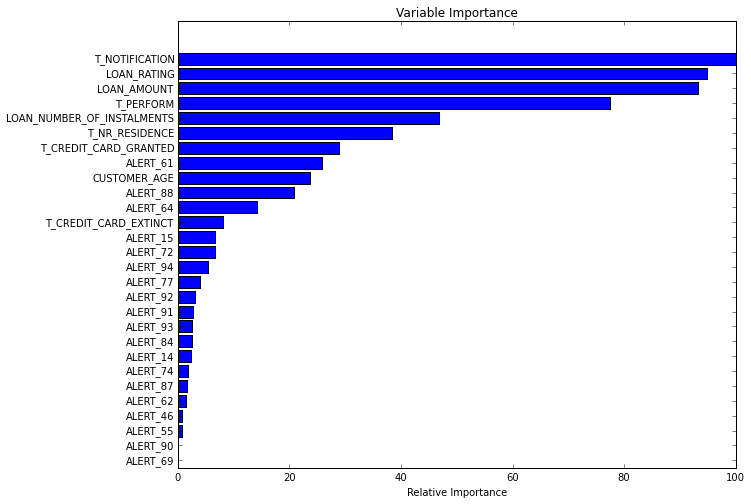

In [43]:
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns.values)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Test set

When you will test the model on a new dataset/new customer you need to submit a dataset with the same features X as above.

Suppose you have a new dataset with the array of features called 'X_test'. You need to fit the model 'model_opt' doing this:

In [44]:
model_opt.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight='auto', criterion='gini',
            max_depth=6, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=140, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

To get the individual PROBABILITY of FRAUD on your new dataset you need to do the following:

In [ ]:
predicted = [i[1] for i in model_opt.predict_proba(X_test)]

To select individual probability of FRAUD for a given threashold, let's say above 0.4:

In [ ]:
print (np.array(predict_prob) > 0.4).astype(int)  # Individual Probability greater than 0.4

### Export individual probability

In [ ]:
with open("model_0.1_feature_selection.tsv", 'w') as f:
    print >>f, "trees: 140, depth: 6, variabili: feature-selection: si"
    for loan_number, probability in zip(sella.index[test_index], predict_prob):
        print >>f, loan_number, probability